# Computer Vision Assignment 1 Part 2
---

Semester: **Fall 2023**

Due date: **October 5th 2023, 11.59PM EST.**

## Introduction
---
This assignment requires you to participate in a Kaggle competition with the rest of the class on the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb). The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the [private link](https://www.kaggle.com/t/f198351e92ff46d5a839fd73d22e9cbc).

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file `gtsrb_kaggle.csv` that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score.

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
---
You should make a copy of this Colab (`File->Save a copy in Drive`). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is NOT ALLOWED! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.

Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models.

## Important Details
---
• You are only allowed 8 submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 95%

• **Extra important:** Please use your NYU NetID as your team name on Kaggle, so the TAs can figure out which user you are on the leaderboard.

# Dataset Preparation
___

1.  Download [`dataset.zip`](https://cs.nyu.edu/~fergus/teaching/vision/dataset.zip) from the course website to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders: `training`, `validation`, and `testing`.
3.  Go to Google Drive (on your NYU account) and make a new directory (say `cv_kaggle_assignment`).
4.  Upload each of the three subfolders to it.
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested.


In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd  /content/drive/'MyDrive'/cv_kaggle_assignment/

Mounted at /content/drive
/content/drive/MyDrive/cv_kaggle_assignment


# Dataloader

In [2]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 5
log_interval = 100

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Model

In [6]:
#construct the new STN model
#explaination of the model structure:
#the STN model mainly contain to parts, the core part of this model is the STN block.
#The STN block mainly consists of a local network, which is a two layer concolutional neural network. Also a local function, which is a two layer perceptron
#The two layer perceptron, which outpouts the prediction for the parameter to implement transformations on the original image. Then the transformed image is fed into the CNN
#By applying this transformation to the image, the model can capture the details in the image better.
#The overall model consists of three layers of convolutional neural network and two STN blocks.
#The detailed parameters and the structure of the model is printed in the code below.
#I refered to the baseline code of this model on Github. The initial model was for the input of size Batch*3*48*48, and by changing some structures and parameters in the model,
#I made the model can successfully make a good performanc on the dataset of this challenge
#This model is based on the paper https://arxiv.org/pdf/1506.02025.pdf
#Code resource: Github Reference: https://github.com/topics/spatial-transformer-network

import torch
import torch.nn as nn
import torch.nn.functional as F
class STN_block(nn.Module):
  def __init__(self,in_channels,in_wh,out_channels_1,out_channels_2,fc_loc_out,kernel_size,stride,padding,index):
    super(STN_block,self).__init__()
    #construct the localization network
    self.index=index
    if index==1:
      self.loc_net=nn.Sequential(
          #first convolution layer
          nn.Conv2d(in_channels,out_channels_1,kernel_size,stride,padding=padding),
          nn.BatchNorm2d(out_channels_1),
          nn.ReLU(),
          nn.MaxPool2d(2),
          #second convolution layer
          nn.Conv2d(out_channels_1,out_channels_2,kernel_size,stride,padding=padding),
          nn.BatchNorm2d(out_channels_2),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
    elif index==2:
       self.loc_net=nn.Sequential(
          #first convolution layer
          nn.Conv2d(in_channels,out_channels_1,kernel_size,stride,padding=padding),
          nn.BatchNorm2d(out_channels_1),
          nn.ReLU(),
          nn.MaxPool2d(2),
          #second convolution layer
          nn.Conv2d(out_channels_1,out_channels_2,kernel_size-2,stride,padding=padding),
          nn.BatchNorm2d(out_channels_2),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
    if index==1:
      self.out_size = (((in_wh - kernel_size + 1) // 2 + padding)  - kernel_size + 1) // 2 + padding
      self.fc_loc_in=out_channels_2*self.out_size*self.out_size
    elif index==2:
      self.out_size = (((in_wh - kernel_size + 1) // 2 + padding)  - (kernel_size-2) + 1) // 2 + padding
      self.fc_loc_in=out_channels_2*self.out_size*self.out_size

    #Regressor for the 3*2 affine matrix
    self.fc_loc=nn.Sequential(
        nn.Linear(self.fc_loc_in,fc_loc_out),
        nn.BatchNorm1d(fc_loc_out),
        nn.ReLU(),
        nn.Linear(fc_loc_out,3*2)
    )

    #initialize the weights/bias with identity transformation
    self.fc_loc[-1].weight.data.zero_()
    self.fc_loc[-1].bias.data.copy_(torch.tensor([1,0,0,0,1,0],dtype=torch.float))

  #define the forward function
  def forward(self,x):
    #print(self.index)
    #print(x.shape)
    x_loc=self.loc_net(x)
    #print(self.out_size,self.fc_loc_in)
    #print(x_loc.shape)
    x_loc=x_loc.view(-1,self.fc_loc_in)
    theta=self.fc_loc(x_loc)
    theta=theta.view(-1,2,3)
    grid=F.affine_grid(theta,x.size(),align_corners=True)
    x=F.grid_sample(x,grid,align_corners=True)
    return x

class Net(nn.Module):
  #we implement 2 STN bolcks with 3 convolutional layers in this model
  def __init__(self,in_channels,in_wh,fc1_dim,num_classes,conv_params):
    super(Net,self).__init__()

    self.stn1=STN_block(in_channels,in_wh, conv_params['stn_ch1'][0],conv_params['stn_ch1'][1], fc_loc_out = 200, kernel_size = 5, stride = 1, padding = 2,index=1)
    self.conv1 = nn.Conv2d(in_channels, conv_params['out_channels'][0], conv_params['kernel_size'][0], conv_params['stride'][0], conv_params['padding'][0])
    self.bn1 = nn.BatchNorm2d(conv_params['out_channels'][0])

    self.conv2 = nn.Conv2d(conv_params['out_channels'][0], conv_params['out_channels'][1], conv_params['kernel_size'][1], conv_params['stride'][1], conv_params['padding'][1])
    self.stn2 = STN_block(conv_params['out_channels'][1], 8, conv_params['stn_ch2'][0], conv_params['stn_ch2'][1], fc_loc_out = 150, kernel_size = 3, stride = 1, padding = 2,index=2)
    self.bn2 = nn.BatchNorm2d(conv_params['out_channels'][1])

    self.conv3 = nn.Conv2d(conv_params['out_channels'][1], conv_params['out_channels'][2], conv_params['kernel_size'][2], conv_params['stride'][2], conv_params['padding'][2])
    self.bn3 = nn.BatchNorm2d(conv_params['out_channels'][2])

    self.fc_dim = conv_params['out_channels'][2] * 4 * 4

    self.fc1 = nn.Linear(self.fc_dim, fc1_dim)
    self.bn4 = nn.BatchNorm1d(fc1_dim)
    self.fc2 = nn.Linear(fc1_dim, num_classes)
    self.drop = nn.Dropout(p=0.5)

  def forward(self, x):
        #the first convolutional layer with the first STN layer
      x = torch.max_pool2d(F.relu(self.bn1(self.conv1(self.stn1(x)))), 2)
      #print('first STN layer finished',x.shape)
        #the second convolutional layer
      x = torch.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
      #print('second conv layer finished',x.shape)
        #the third convolutional layer with the second STN layer
      x = torch.max_pool2d(F.relu(self.bn3(self.conv3(self.stn2(x)))), 2)
      #print('third STN layer finished',x.shape)
      x = x.view(-1, self.fc_dim)
      x=self.fc1(x)
      #print(x.shape)
      x=self.bn4(x)
      #print(x.shape)
      x = F.relu(x)
      x = self.fc2(self.drop(x))
      return F.log_softmax(x, dim=1)


In [10]:
# Model Parameters:
in_channels=3
in_wh=32
fc1_dim=150
num_classes = 43

conv_params = {
     'out_channels':[150,200,300],
     'kernel_size':[7,4,4],
     'stride':[1,1,1],
     'padding':[2,2,2],
     'stn_ch1':[200, 300],
     'stn_ch2': [150, 150],
}

model = Net(in_channels, in_wh, fc1_dim, num_classes, conv_params)
print(model)

Net(
  (stn1): STN_block(
    (loc_net): Sequential(
      (0): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(200, 300, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (5): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_loc): Sequential(
      (0): Linear(in_features=19200, out_features=200, bias=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=200, out_features=6, bias=True)
    )
  )
  (conv1): Conv2d(3, 150, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(150, eps=1e-05, momen

In [ ]:
from torchsummary import summary
model.to('cuda')
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 200, 32, 32]          15,200
       BatchNorm2d-2          [-1, 200, 32, 32]             400
              ReLU-3          [-1, 200, 32, 32]               0
         MaxPool2d-4          [-1, 200, 16, 16]               0
            Conv2d-5          [-1, 300, 16, 16]       1,500,300
       BatchNorm2d-6          [-1, 300, 16, 16]             600
              ReLU-7          [-1, 300, 16, 16]               0
         MaxPool2d-8            [-1, 300, 8, 8]               0
            Linear-9                  [-1, 200]       3,840,200
      BatchNorm1d-10                  [-1, 200]             400
             ReLU-11                  [-1, 200]               0
           Linear-12                    [-1, 6]           1,206
        STN_block-13            [-1, 3, 32, 32]               0
           Conv2d-14          [-1, 150,

# Training

In [ ]:
model.load_state_dict(torch.load('model_STN_939.pth'))

<All keys matched successfully>

In [11]:
#use swall model to improve the performance of model
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
#I use the training technique of stochastic weighting average to train the model
#I found this technique based on https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/

swa_model = AveragedModel(model)
swa_model=swa_model.to('cuda')

In [ ]:
import torch.optim as optim
epochs=300
swa_start=40
swa_lr=5e-5
weight_decay = 0.0001

#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas = (0.9,0.999))
#optimizer = optim.Nadam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
#Here I set a scheduler to adjust the learning rate.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)
swa_scheduler=SWALR(optimizer, swa_lr = swa_lr)

In [ ]:
#model = Net(in_channels, in_wh, fc1_dim, num_classes, conv_params)

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas = (0.9,0.999))
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data=data.to('cuda')
        target=target.to('cuda')
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def validation(model,scheduler):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data=data.to('cuda')
        target=target.to('cuda')
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)

    scheduler.step(validation_loss)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss

lst_train_loss=[]
lst_validation_loss=[]

for epoch in range(swa_start):
    lst_train_loss.append(train(epoch))
    lst_validation_loss.append(validation(model,scheduler))
    model_file = 'model_STN_10' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

for epoch in range(swa_start,epochs):
     lst_train_loss.append(train(epoch))
     swa_model.update_parameters(model)
     torch.optim.swa_utils.update_bn(train_loader, swa_model,device='cuda')
     lst_validation_loss.append(validation(swa_model,swa_scheduler))
     model_file = 'model_STN_swa3' + str(epoch) + '.pth'
     torch.save(swa_model.state_dict(), model_file)
     print('\nSaved swa model to ' + model_file + '.')


Train Epoch: 0 [0/35339 (0%)]	Loss: 0.000005
Train Epoch: 0 [3200/35339 (9%)]	Loss: 0.000006
Train Epoch: 0 [6400/35339 (18%)]	Loss: 0.000153
Train Epoch: 0 [9600/35339 (27%)]	Loss: 0.000069
Train Epoch: 0 [12800/35339 (36%)]	Loss: 0.000122
Train Epoch: 0 [16000/35339 (45%)]	Loss: 0.000037
Train Epoch: 0 [19200/35339 (54%)]	Loss: 0.002719
Train Epoch: 0 [22400/35339 (63%)]	Loss: 0.000106
Train Epoch: 0 [25600/35339 (72%)]	Loss: 0.002859
Train Epoch: 0 [28800/35339 (81%)]	Loss: 0.000249
Train Epoch: 0 [32000/35339 (90%)]	Loss: 0.000891
Train Epoch: 0 [35200/35339 (100%)]	Loss: 0.004557

Validation set: Average loss: 0.1787, Accuracy: 3719/3870 (96%)


Saved model to model_STN_100.pth.
Train Epoch: 1 [0/35339 (0%)]	Loss: 0.062700
Train Epoch: 1 [3200/35339 (9%)]	Loss: 0.000009
Train Epoch: 1 [6400/35339 (18%)]	Loss: 0.008768
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.000081
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.000399
Train Epoch: 1 [16000/35339 (45%)]	Loss: 0.000132
Train Epoch: 1 [

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 41 [0/35339 (0%)]	Loss: 0.000011
Train Epoch: 41 [3200/35339 (9%)]	Loss: 0.000023
Train Epoch: 41 [6400/35339 (18%)]	Loss: 0.000149
Train Epoch: 41 [9600/35339 (27%)]	Loss: 0.000136
Train Epoch: 41 [12800/35339 (36%)]	Loss: 0.000005
Train Epoch: 41 [16000/35339 (45%)]	Loss: 0.000262
Train Epoch: 41 [19200/35339 (54%)]	Loss: 0.000053
Train Epoch: 41 [22400/35339 (63%)]	Loss: 0.000027
Train Epoch: 41 [25600/35339 (72%)]	Loss: 0.000185
Train Epoch: 41 [28800/35339 (81%)]	Loss: 0.000135
Train Epoch: 41 [32000/35339 (90%)]	Loss: 0.000544
Train Epoch: 41 [35200/35339 (100%)]	Loss: 0.000042

Validation set: Average loss: 0.1112, Accuracy: 3759/3870 (97%)


Saved swa model to model_STN_swa341.pth.
Train Epoch: 42 [0/35339 (0%)]	Loss: 0.000004
Train Epoch: 42 [3200/35339 (9%)]	Loss: 0.000111
Train Epoch: 42 [6400/35339 (18%)]	Loss: 0.000046
Train Epoch: 42 [9600/35339 (27%)]	Loss: 0.000007
Train Epoch: 42 [12800/35339 (36%)]	Loss: 0.000043
Train Epoch: 42 [16000/35339 (45%)]	Loss: 

In [ ]:
#model_STN_12.pth and  model_STN_17.pth is of test accuracy 96%
#model_STN_24.pth is of accuracy 96% 3728/3870

Text(0, 0.5, 'loss')

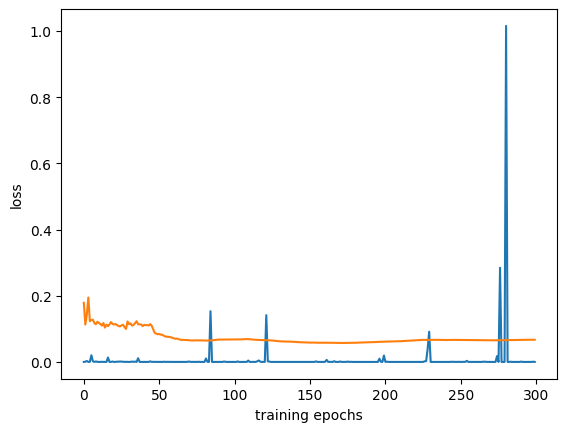

In [ ]:
#plot the training loss and validation loss
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(lst_train_loss))],lst_train_loss,label='training loss')
plt.plot([i for i in range(len(lst_validation_loss))],lst_validation_loss,label='validation_loss')
plt.xlabel('training epochs')
plt.ylabel('loss')

# Evaluate and Submit to Kaggle



In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_swa_final.csv'

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

swa_model.eval() # Don't forget to put your model on eval mode !
for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    data=data.to('cuda')
    output = swa_model(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))


Written to csv file gtsrb_kaggle_swa_final.csv


In [13]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle_swa_final_final.csv'

output_file = open(outfile, "w")
dataframe_dict = {"Filename" : [], "ClassId": []}

model_99=AveragedModel(Net(in_channels, in_wh, fc1_dim, num_classes, conv_params))
model_99.load_state_dict(torch.load('model_STN_swa3251.pth'))
model_99=model_99.to('cuda')

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))
model_99.eval() # Don't forget to put your model on eval mode !

for i, data in enumerate(test_data):
    data = data.unsqueeze(0)
    data=data.to('cuda')
    output = model_99(data)
    pred = output.data.max(1, keepdim=True)[1].item()
    file_id = file_ids[i][0:5]
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(pred)

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

Written to csv file gtsrb_kaggle_swa_final_final.csv


# Submitting to Kaggle

Now download the CSV file `grtsrb_kaggle.csv` from your Google drive and then submit it to Kaggle to check the performance of your model.

**Extra important:** Please use your NYU NetID as your team name on Kaggle, or your submissions will not be evaluated.  
You can rename your team easily from the Team tab: https://www.kaggle.com/competitions/nyu-computer-vision-csci-ga2271-2022/team.